In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
sentiment_df = pd.read_csv('fear_greed_index.csv')
trader_df = pd.read_csv('historical_data.csv')

In [15]:
sentiment_df.columns = sentiment_df.columns.str.strip()
trader_df.columns = trader_df.columns.str.strip()

In [16]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")
trader_df['trade_date'] = trader_df['Timestamp IST'].dt.date

In [17]:
merged_df = pd.merge(trader_df, sentiment_df, left_on='trade_date', right_on='date', how='inner')

In [18]:
merged_df['profit'] = merged_df['Closed PnL'] > 0  # profitable or not
merged_df['trade_type'] = merged_df['Side'].apply(lambda x: 'Buy' if x.upper() == 'BUY' else 'Sell')

In [21]:
print(merged_df.groupby('classification')['Closed PnL'].mean())
print(merged_df.groupby('classification')['profit'].mean())

classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: profit, dtype: float64


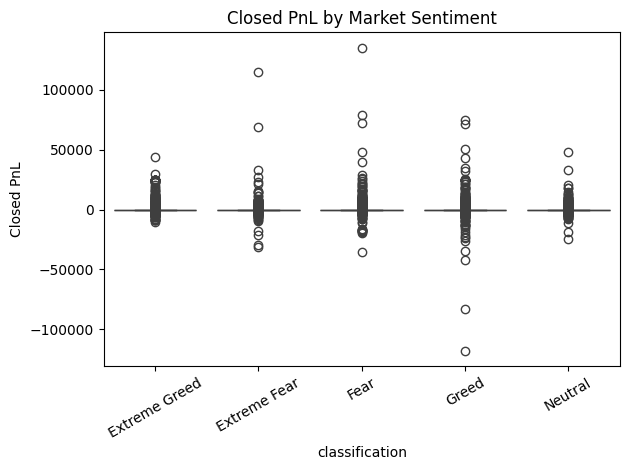

In [20]:
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title('Closed PnL by Market Sentiment')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [22]:
symbol_analysis = merged_df.groupby(['Coin', 'classification'])['Closed PnL'].mean().unstack()
print(symbol_analysis)

classification  Extreme Fear  Extreme Greed       Fear      Greed    Neutral
Coin                                                                        
@1                       NaN      18.358058   0.000000   0.179780        NaN
@10                -0.031742            NaN   0.000000   0.000000        NaN
@100                     NaN       6.906785        NaN        NaN        NaN
@103                     NaN       6.812669        NaN   2.247346        NaN
@107              -89.588788     191.158211  -2.291257  86.251763  52.150107
...                      ...            ...        ...        ...        ...
kBONK                    NaN      50.274649  24.736833  -2.724259   0.896872
kFLOKI                   NaN      50.216813        NaN  15.543654   4.083950
kNEIRO                   NaN            NaN        NaN   2.039936  -2.840308
kPEPE               0.230600      22.337976  31.460104 -14.880396  -0.951026
kSHIB               0.000000       8.832210  13.644264   0.000000   0.526700

In [23]:
greed_df = merged_df[merged_df['classification'].str.contains('Greed', case=False)]

In [24]:
top5_greed_coins = greed_df.groupby('Coin')['Closed PnL'].mean().sort_values(ascending=False).head(5)
print("Top 5 Profitable Coins on Greed Days:")
print(top5_greed_coins)

Top 5 Profitable Coins on Greed Days:
Coin
PEOPLE     360.646005
@109       338.348370
@85        288.110217
BERA       202.047489
MOODENG    156.815630
Name: Closed PnL, dtype: float64


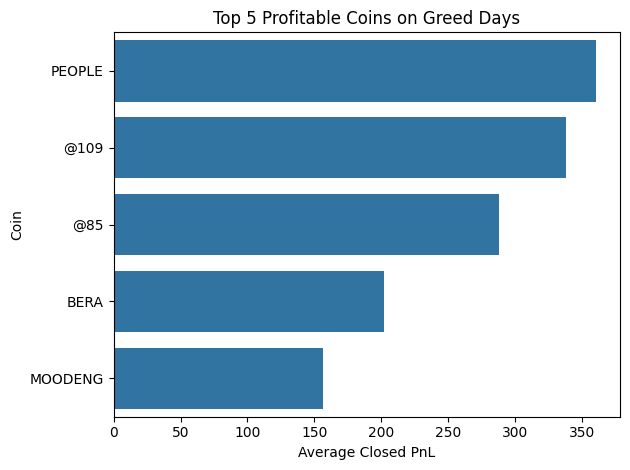

In [25]:
sns.barplot(x=top5_greed_coins.values, y=top5_greed_coins.index)
plt.title("Top 5 Profitable Coins on Greed Days")
plt.xlabel("Average Closed PnL")
plt.ylabel("Coin")
plt.tight_layout()
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [27]:
merged_df['sentiment_code'] = merged_df['classification'].astype('category').cat.codes

In [28]:
merged_df['side_code'] = merged_df['Side'].astype('category').cat.codes

In [29]:
features = ['sentiment_code', 'side_code', 'Size USD']
X = merged_df[features]
y = merged_df['profit']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

       False       0.71      0.71      0.71     24848
        True       0.59      0.59      0.59     17396

    accuracy                           0.66     42244
   macro avg       0.65      0.65      0.65     42244
weighted avg       0.66      0.66      0.66     42244



In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 66.01%
